## Automated Machine Learning
We will be working with [Heart Failure Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

### Libraries
- [HyperOpt](https://hyperopt.github.io/hyperopt/) ([Tutorial 1](https://towardsdatascience.com/optimise-your-hyperparameter-tuning-with-hyperopt-861573239eb5), [Tutorial 2](https://medium.com/vooban-ai/hyperopt-tutorial-for-optimizing-neural-networks-hyperparameters-e3102814b919))


### Instructions
1. Choose a dataset. Build and train a baseline for comparison. Try a set of possible machine learning algorithms (13 algorithms) using their default hyperparamters and choose the one with the highest performance for comparison.

2. Based on the problem at hand, you study the potential pipeline structure,
algorithms or feature transformers at each step, hyper-parameters ranges. Use
hyperOpt with the potential search space to beat the baseline.

3. Monitor the performance of you the constructed pipeline from the previous step across different time budgets (number of iterations) and report the least time budget that you are able to outperform the baseline.

4. Determine whether the difference in performance between the constructed pipeline and the baseline is statistically significant.

In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import seaborn as sn

In [2]:
df = pd.read_csv('./heart_failure.csv')
df.sample(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
717,49,F,ASY,130,269,0,Normal,163,N,0.0,Up,0
124,58,M,ATA,130,230,0,Normal,150,N,0.0,Up,0
691,45,M,ASY,104,208,0,LVH,148,Y,3.0,Flat,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
from sklearn.model_selection import train_test_split
from util import find_baseline, preprocess

df = preprocess(df)
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)
scores = find_baseline(train_df)

/Users/felix/Documents/Studium/Uni_Augsburg/Semester6/AutoML/project1/venv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/felix/Documents/Studium/Uni_Augsburg/Semester6/AutoML/project1/venv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [5]:
for name, score in sorted(scores.items(), key=lambda t: t[1], reverse=True):
    print(f'{name:20}: {score:.3f}')

Naive Bayes         : 0.850
Random Forest       : 0.844
AdaBoost            : 0.844
Logistic Regression : 0.844
QDA                 : 0.833
SVM                 : 0.831
Neural Network      : 0.823
Decision Tree       : 0.802
Gaussian Process    : 0.746
KNN                 : 0.712


In [6]:
baseline_model = max(scores, key=scores.get)
baseline_score = scores[baseline_model]
print(f"Baseline model is {baseline_model} with accuracy {baseline_score:.4f}.")

Baseline model is Naive Bayes with accuracy 0.8504.


In [56]:
from project1.util import create_objective
from util import preprocess, optimize_hyperparams, classifiers, search_spaces, pd_insert_row
from hyperopt import fmin, space_eval, hp, tpe, STATUS_OK, Trials

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X_train = train_df.drop('HeartDisease', axis=1).values
X_test = test_df.drop('HeartDisease', axis=1).values

y_train = train_df['HeartDisease'].values
y_test = test_df['HeartDisease'].values

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

min_budget_score = pd.DataFrame(columns=['Classifier', 'Minimum_Budget', 'Accuracy'])

# for classifier_name in search_spaces.keys():
for classifier_name in search_spaces.keys():
    def early_stop(result, *_):
        params = space_eval(search_spaces[classifier_name], trials.argmin)
        model = classifiers[classifier_name](**params, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        result.attachments['recent_score'] = acc

        return acc > baseline_score, []

    trials = Trials()

    optimized_params = fmin(
        fn=create_objective(classifier_name, df, scale_values=True),
        space=search_spaces[classifier_name],
        algo=tpe.suggest,
        max_evals=100,
        trials=trials,
        verbose=False,
        rstate=np.random.default_rng(42),
        early_stop_fn=early_stop,
        return_argmin=False
    )

    losses = [trial['result']['loss'] for trial in trials]

    min_budget_score = pd_insert_row(min_budget_score, [classifier_name, len(trials), trials.attachments['recent_score']])


min_budget_score

/Users/felix/Documents/Studium/Uni_Augsburg/Semester6/AutoML/project1/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/felix/Documents/Studium/Uni_Augsburg/Semester6/AutoML/project1/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/felix/Documents/Studium/Uni_Augsburg/Semester6/Au

,Classifier,Minimum_Budget,Accuracy
0,Neural Network,3,0.851485
1,AdaBoost,1,0.867987
2,Logistic Regression,1,0.851485
3,Random Forest,1,0.881188


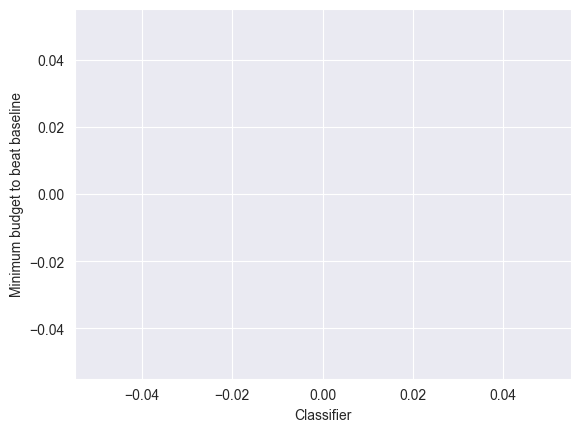

In [23]:
from matplotlib import pyplot as plt

plt.bar(min_budget_score['Classifier'], min_budget_score['Minimum_Budget'])
plt.xlabel("Classifier")
plt.ylabel("Minimum budget to beat baseline")
plt.show()

In [ ]:
def two_matched_t(acc1, acc2, results_1, results_2, n_samples):
    # See Lecture 2 Evaluation pp. 71
    d_overscore = abs(acc1 - acc2)
    d = abs(results_1 - results_2)
    var = np.sum((d - d_overscore) ** 2) / (n_samples - 1)
    s_d = np.sqrt(var)
    t = d_overscore * np.sqrt(n_samples) / s_d
    return t

In [8]:
from matplotlib import pyplot as plt

def visualise_search(losses, baseline):
    baseline = 1 - baseline
    plt.plot(range(len(losses)), losses, linewidth=0.8, alpha=0.5)
    plt.plot([0, len(losses)], [baseline, baseline], linestyle='dashed', linewidth=0.5, color='red', alpha=0.8)
    plt.ylim(0, 0.2)
    plt.show()
